In [2]:
!nvidia-smi

Sat Oct 12 14:25:13 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 80GB HBM3          Off |   00000000:46:00.0 Off |                    0 |
| N/A   44C    P0            101W /  700W |       1MiB /  81559MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
%matplotlib inline

import torch
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# Muon optimizer

def zeropower_via_svd(G, steps=None):
    U, S, V = G.svd()
    return U @ V.T

@torch.compile
def zeropower_via_newtonschulz5(G, steps=10, eps=1e-7):
    r"""
    Newton-Schulz iteration to compute the zeroth power / orthogonalization of G. We opt to use a
    quintic iteration whose coefficients are selected to maximize the slope at zero. For the purpose
    of minimizing steps, it turns out to be empirically effective to keep increasing the slope at
    zero even beyond the point where the iteration no longer converges all the way to one everywhere
    on the interval. This iteration therefore does not produce UV^T but rather something like US'V^T
    where S' is diagonal with S_{ii}' \sim Uniform(0.5, 1.5), which turns out not to hurt model
    performance at all relative to UV^T, where USV^T = G is the SVD.
    """
    assert len(G.shape) == 2
    a, b, c = (3.4445, -4.7750,  2.0315)
    X = G.bfloat16() / (G.norm() + eps) # ensure top singular value <= 1
    if G.size(0) > G.size(1):
        X = X.T
    for _ in range(steps):
        A = X @ X.T
        B = A @ X
        X = a * X + b * B + c * A @ B
    if G.size(0) > G.size(1):
        X = X.T
    return X.to(G.dtype)

zeropower_backends = dict(svd=zeropower_via_svd, newtonschulz5=zeropower_via_newtonschulz5)

class Muon(torch.optim.Optimizer):
    r"""
    Muon - MomentUm Orthogonalized by Newton-schulz

    Muon internally runs standard SGD-momentum, and then performs an orthogonalization post-
    processing step, in which each 2D parameter's update is replaced with the nearest orthogonal
    matrix. To efficiently orthogonalize each update, we use a Newton-Schulz iteration, which has
    the advantage that it can be stably run in bfloat16 on the GPU.

    Some warnings:
    - This optimizer assumes that all parameters passed in are 2D.
    - It should not be used for the embedding layer, the final fully connected layer, or any {0,1}-D
    parameters; those should all be optimized by a standard method (e.g., AdamW).
    - To use it with 4D convolutional filters, it works well to just flatten their last 3 dimensions.
    - We believe it is unlikely to work well for training with small batch size.
    - We believe it may not work well for finetuning pretrained models, but we haven't tested this.
    - We have not yet tried this optimizer for training scenarios larger than NanoGPT (124M).

    Arguments:
        lr: The learning rate used by the internal SGD.
        momentum: The momentum used by the internal SGD.
        nesterov: Whether to use Nesterov-style momentum in the internal SGD. (recommended)
        backend: The chosen backend for the orthogonalization step. (recommended: 'newtonschulz5')
        backend_steps: The number of iteration steps to use in the backend, if it is iterative.
    """
    def __init__(self, params, lr=3e-4, momentum=0.95, nesterov=True, backend='newtonschulz5', backend_steps=5):
        defaults = dict(lr=lr, momentum=momentum, nesterov=nesterov, backend=backend, backend_steps=backend_steps)
        super().__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            lr = group['lr']
            momentum = group['momentum']
            zeropower_backend = zeropower_backends[group['backend']]
            for p in group['params']:
                g = p.grad
                if g is None:
                    continue
                state = self.state[p]
                if 'momentum_buffer' not in state:
                    state['momentum_buffer'] = torch.zeros_like(g)
                buf = state['momentum_buffer']
                buf.mul_(momentum).add_(g)
                if group['nesterov']:
                    g = g.add(buf, alpha=momentum)
                if g.size(0) == 3 * g.size(1): # split grouped QKV parameters; following @bozavlado's finding
                    g = torch.cat([zeropower_backend(g1, steps=group['backend_steps']) for g1 in g.split(g.size(1))])
                    scale = g.size(1)**0.5
                else:
                    g = zeropower_backend(g, steps=group['backend_steps'])
                    scale = max(g.size(0), g.size(1))**0.5 # scale to have update.square().mean() == 1
                p.data.add_(g, alpha=-lr * scale)

In [8]:
# mnist training loop
from typing import Optional
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from collections import namedtuple

def train_mnist(model, opt, num_epochs=10, batch_size=512, w_save_key: Optional[str] = None):
    # Hyperparameters
    learning_rate = 0.001
    # device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dtype = next(iter(model.parameters())).dtype
    print(f'training on {device}, {dtype}')

    # Data loading
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST(root='./mnist_data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = datasets.MNIST(root='./mnist_data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size * 2, shuffle=False)

    # Assuming model is already defined and named "model"
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizers = []
    if opt == 'adam':
        optimizers.append(
            optim.Adam(model.parameters(), lr=learning_rate)  # Using Adam optimizer
        )
    elif opt == 'muon':
        optimizers.extend([
            Muon([p for p in model.parameters() if len(p.data.shape) == 2], lr=learning_rate),
            optim.Adam([p for p in model.parameters() if len(p.data.shape) != 2], lr=learning_rate),
        ])
    else:
        raise ValueError(f"Unknown optimizer: {opt}")

    @torch.no_grad()
    def evaluate(model, loader):
        model.eval()
        correct = 0
        total = 0
        for data, target in loader:
            data, target = data.to(device, dtype), target.to(device)
            output = model(data.flatten(1))
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        return correct / total

    # Training loop
    model_ws = []
    train_accs = []
    eval_accs = []

    def record():
        train_acc = evaluate(model, train_loader)
        eval_acc = evaluate(model, test_loader)
        eval_accs.append(eval_acc)
        train_accs.append(train_acc)
        if w_save_key is not None:
            model_ws.append(
                model.state_dict()[w_save_key].to('cpu', torch.float32).data
            )
        print(f"Epoch {len(eval_accs)-1}/{num_epochs}, Train Accuracy: {train_acc:.2%}, Test Accuracy: {eval_acc:.2%}")
        print('-' * 100)

    record()

    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device, dtype), target.to(device)

            model.zero_grad()
            output = model(data.flatten(1))
            loss = criterion(output, target)
            loss.backward()
            for optimizer in optimizers:
                optimizer.step()

            if batch_idx % 200 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")

        record()

    print("Training completed!")

    return namedtuple('TrainResult', ['train_accs', 'eval_accs', 'model_ws'])(train_accs, eval_accs, model_ws)


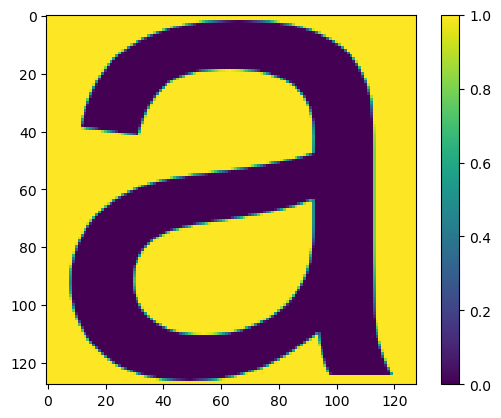

In [9]:
# convert letter a in font sans serif to matrix indicator
def letter_a_to_matrix(size=10):
    import numpy as np
    from PIL import Image, ImageDraw, ImageFont

    # Create a blank image
    img = Image.new('L', (size, size), color=255)
    draw = ImageDraw.Draw(img)

    # Load a sans-serif font
    try:
        font = ImageFont.truetype("Arial.ttf", size)
    except IOError:
        font = ImageFont.load_default()

    # Draw the letter 'a'
    draw.text((0, 0), 'a', font=font, fill=0)

    # Convert to numpy array
    matrix = np.array(img)

    # Convert to binary (0 and 1)
    # matrix = (matrix < 128).astype(int)

    return matrix

# Example usage:
a_matrix_784 = letter_a_to_matrix(52 * 28-20)[:-118][:, 0:][-28*28:, :28*28] / 255.
a_matrix_128 = letter_a_to_matrix(52 * 5-27)[:-19][:, 0:][-128:, :128] / 255.

plt.imshow(a_matrix_128, interpolation='nearest')
plt.colorbar()
plt.show()

In [29]:
model = nn.Sequential(
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
).to(torch.bfloat16)

model = torch.compile(model)

random_init_weights = {k: v.clone().detach() for k, v in model.state_dict().items()}
model._orig_mod[2].weight.data += torch.as_tensor(a_matrix_128).float() * 0.4
a_matrix_weights = {k: v.clone().detach() for k, v in model.state_dict().items()}

viz_w_fn = lambda w: plt.imshow(w.to('cpu', torch.float32).data, vmin=-0.05, vmax=0.45, interpolation='nearest') and plt.colorbar() and plt.show()
viz_sd_fn = lambda sd: viz_w_fn(sd['_orig_mod.2.weight'])

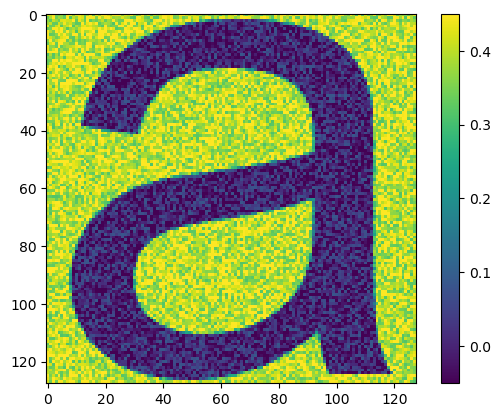

In [31]:
viz_sd_fn(a_matrix_weights)

In [106]:
model.load_state_dict(random_init_weights)
rand_adam_res = train_mnist(model, opt='adam', w_save_key='_orig_mod.2.weight')

rand_adam_trained_weights = {k: v.clone().detach() for k, v in model.state_dict().items()}

training on cuda, torch.bfloat16
Epoch 0/10, Train Accuracy: 9.76%, Test Accuracy: 9.36%
----------------------------------------------------------------------------------------------------
Epoch 1/10, Batch 0/118, Loss: 2.3125
Epoch 1/10, Train Accuracy: 92.37%, Test Accuracy: 92.55%
----------------------------------------------------------------------------------------------------
Epoch 2/10, Batch 0/118, Loss: 0.2520
Epoch 2/10, Train Accuracy: 94.51%, Test Accuracy: 94.15%
----------------------------------------------------------------------------------------------------
Epoch 3/10, Batch 0/118, Loss: 0.1562
Epoch 3/10, Train Accuracy: 96.17%, Test Accuracy: 95.81%
----------------------------------------------------------------------------------------------------
Epoch 4/10, Batch 0/118, Loss: 0.0928
Epoch 4/10, Train Accuracy: 96.75%, Test Accuracy: 96.18%
----------------------------------------------------------------------------------------------------
Epoch 5/10, Batch 0/11

In [12]:
model.load_state_dict(a_matrix_weights)
adam_res = train_mnist(model, opt='adam', w_save_key='_orig_mod.2.weight')

a_adam_trained_weights = {k: v.clone().detach() for k, v in model.state_dict().items()}

training on cuda, torch.bfloat16
Epoch 0/10, Train Accuracy: 12.52%, Test Accuracy: 12.56%
----------------------------------------------------------------------------------------------------
Epoch 1/10, Batch 0/118, Loss: 3.0156
Epoch 1/10, Train Accuracy: 91.46%, Test Accuracy: 91.24%
----------------------------------------------------------------------------------------------------
Epoch 2/10, Batch 0/118, Loss: 0.3496
Epoch 2/10, Train Accuracy: 94.60%, Test Accuracy: 94.25%
----------------------------------------------------------------------------------------------------
Epoch 3/10, Batch 0/118, Loss: 0.2041
Epoch 3/10, Train Accuracy: 95.97%, Test Accuracy: 95.34%
----------------------------------------------------------------------------------------------------
Epoch 4/10, Batch 0/118, Loss: 0.1719
Epoch 4/10, Train Accuracy: 96.48%, Test Accuracy: 95.70%
----------------------------------------------------------------------------------------------------
Epoch 5/10, Batch 0/

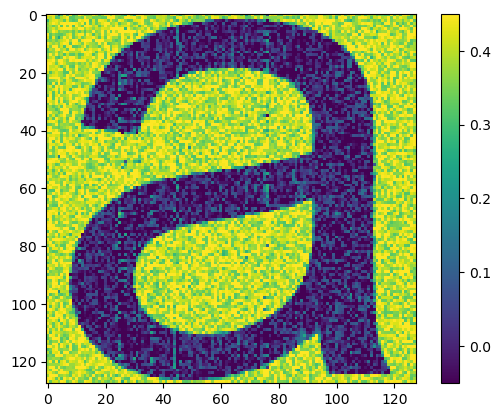

In [14]:
viz_sd_fn(a_adam_trained_weights)


In [15]:
model.load_state_dict(a_matrix_weights)
muon_res = train_mnist(model, opt='muon', w_save_key='_orig_mod.2.weight')

a_muon_trained_weights = {k: v.clone().detach() for k, v in model.state_dict().items()}

training on cuda, torch.bfloat16
Epoch 0/10, Train Accuracy: 12.52%, Test Accuracy: 12.56%
----------------------------------------------------------------------------------------------------
Epoch 1/10, Batch 0/118, Loss: 3.0625
Epoch 1/10, Train Accuracy: 97.04%, Test Accuracy: 96.07%
----------------------------------------------------------------------------------------------------
Epoch 2/10, Batch 0/118, Loss: 0.0693
Epoch 2/10, Train Accuracy: 98.40%, Test Accuracy: 96.90%
----------------------------------------------------------------------------------------------------
Epoch 3/10, Batch 0/118, Loss: 0.0439
Epoch 3/10, Train Accuracy: 98.73%, Test Accuracy: 96.54%
----------------------------------------------------------------------------------------------------
Epoch 4/10, Batch 0/118, Loss: 0.0598
Epoch 4/10, Train Accuracy: 98.97%, Test Accuracy: 96.80%
----------------------------------------------------------------------------------------------------
Epoch 5/10, Batch 0/

In [107]:
model.load_state_dict(random_init_weights)
rand_muon_res = train_mnist(model, opt='muon', w_save_key='_orig_mod.2.weight')

rand_muon_trained_weights = {k: v.clone().detach() for k, v in model.state_dict().items()}

training on cuda, torch.bfloat16
Epoch 0/10, Train Accuracy: 9.76%, Test Accuracy: 9.36%
----------------------------------------------------------------------------------------------------
Epoch 1/10, Batch 0/118, Loss: 2.3125
Epoch 1/10, Train Accuracy: 97.25%, Test Accuracy: 96.46%
----------------------------------------------------------------------------------------------------
Epoch 2/10, Batch 0/118, Loss: 0.0737
Epoch 2/10, Train Accuracy: 98.69%, Test Accuracy: 97.01%
----------------------------------------------------------------------------------------------------
Epoch 3/10, Batch 0/118, Loss: 0.0383
Epoch 3/10, Train Accuracy: 99.02%, Test Accuracy: 97.42%
----------------------------------------------------------------------------------------------------
Epoch 4/10, Batch 0/118, Loss: 0.0483
Epoch 4/10, Train Accuracy: 99.26%, Test Accuracy: 97.51%
----------------------------------------------------------------------------------------------------
Epoch 5/10, Batch 0/11

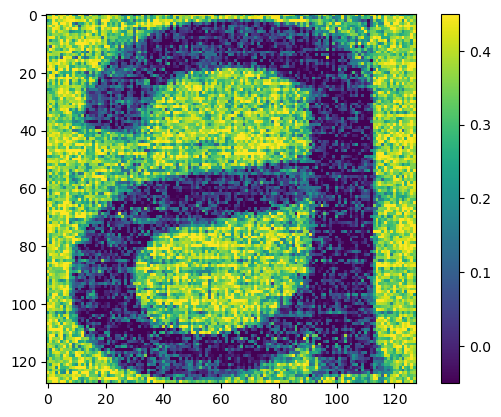

In [16]:
viz_sd_fn(a_muon_trained_weights)


In [134]:
def matrix_spectral_norm(w):
    """
    Compute the spectral norm of a matrix using Singular Value Decomposition (SVD).

    Args:
    w (torch.Tensor): The input matrix

    Returns:
    float: The spectral norm of the matrix
    """
    if w.dim() > 2:
        w = w.view(w.size(0), -1)

    # Compute SVD
    _, s, _ = torch.svd(w)

    # The spectral norm is the largest singular value
    return s[0].item()




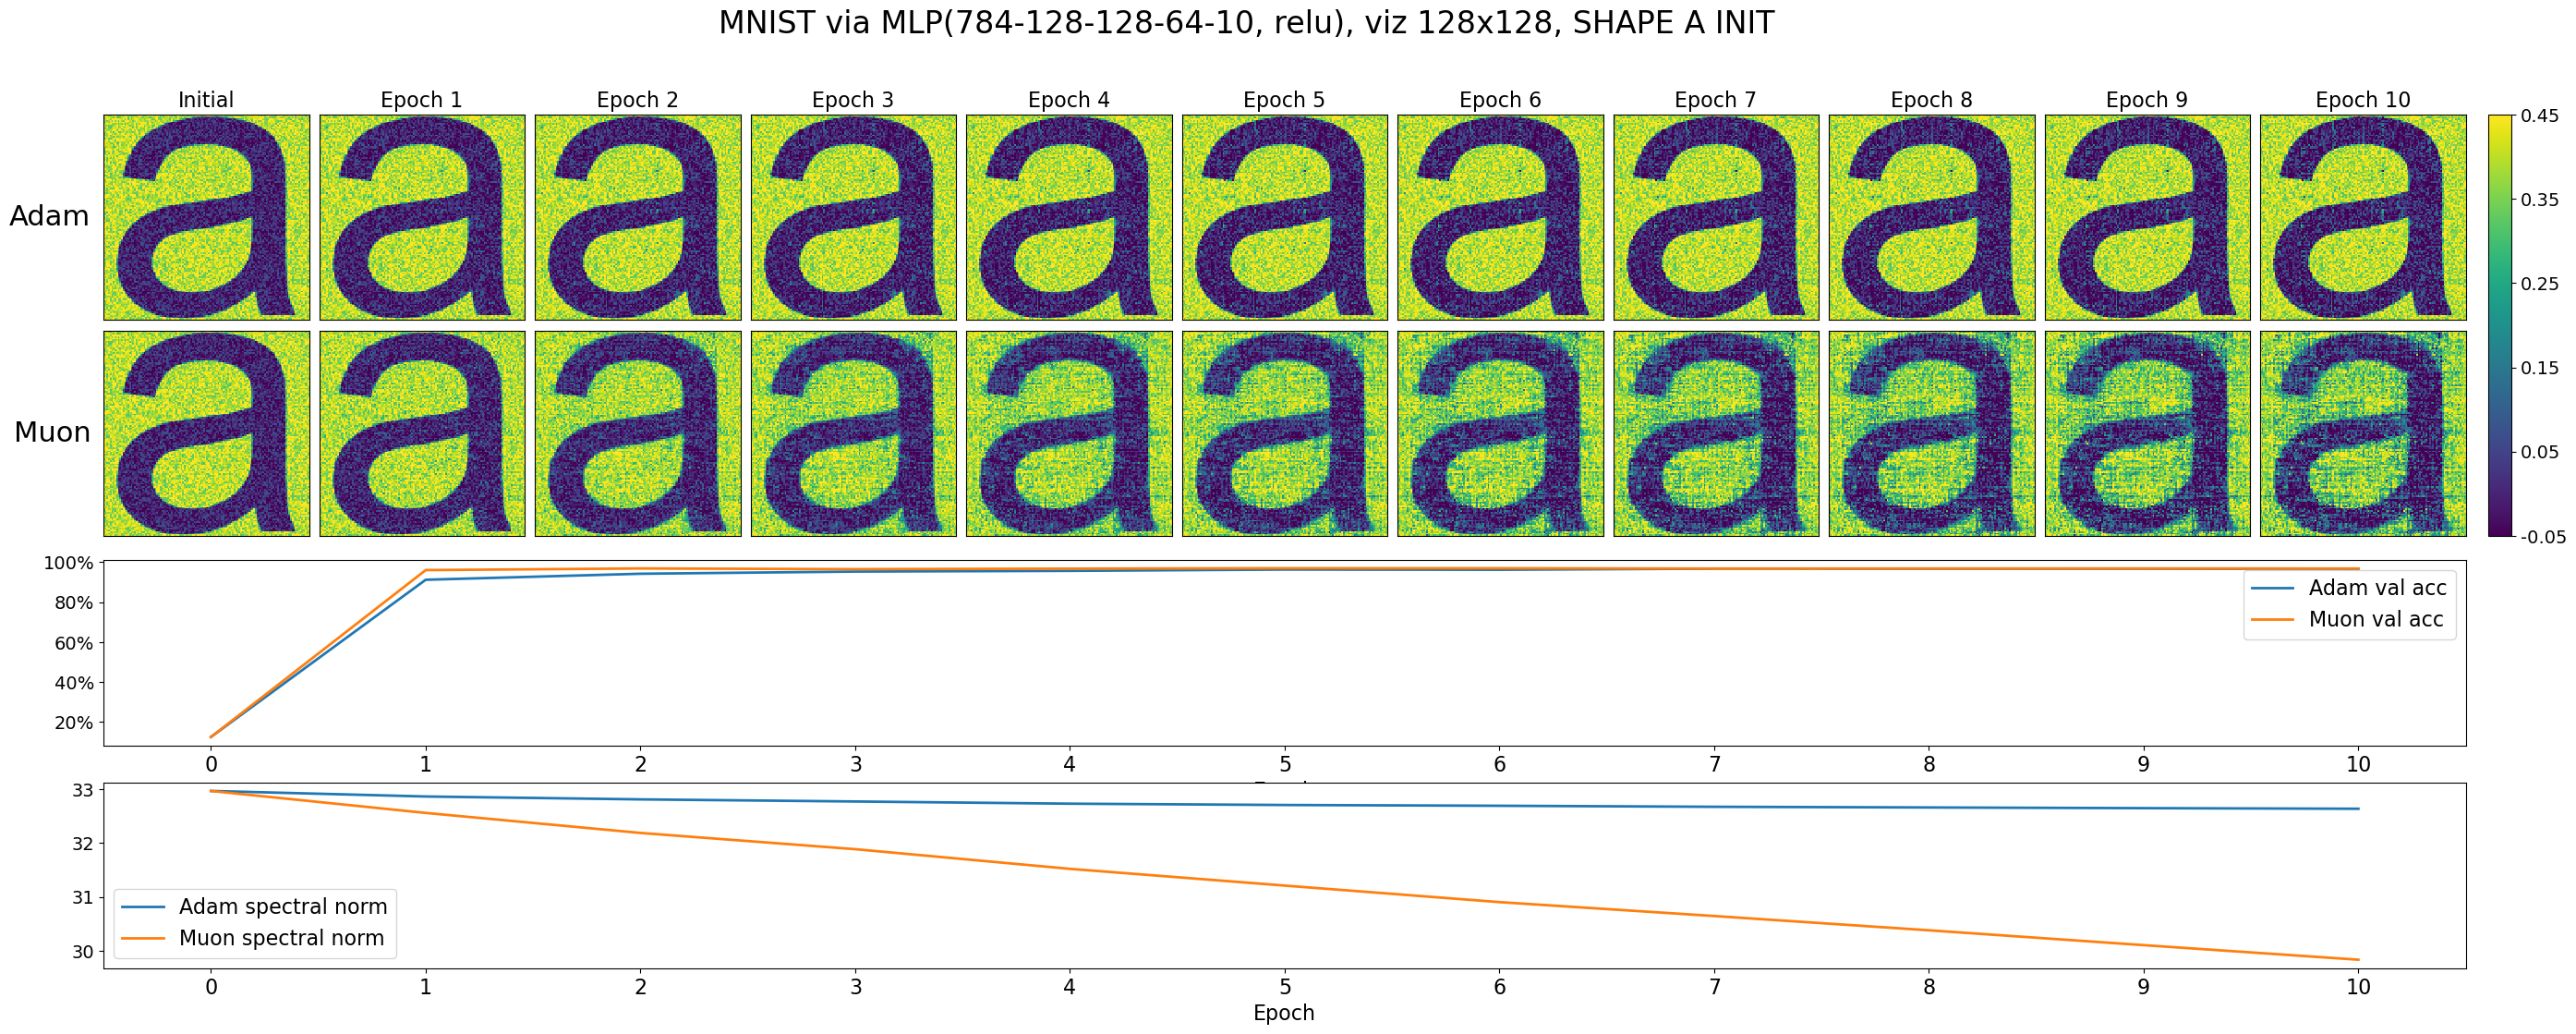

In [132]:
fig, axes = plt.subplots(4, 11, figsize=(11 * 3, 4 * 3), gridspec_kw=dict(wspace=0.05, hspace=0.05))

# Remove the individual axes in the bottom half
for i in range(2, axes.shape[0]):
    for j in range(axes.shape[1]):
        fig.delaxes(axes[i, j])
bottom_ax = fig.add_subplot(4, 1, 3)
bottom2_ax = fig.add_subplot(4, 1, 4)

fig.suptitle('MNIST via MLP(784-128-128-64-10, relu), viz 128x128, SHAPE A INIT', fontsize=24, y=0.975)
axes[0, 0].set_ylabel('Adam', fontsize=22, rotation=0, ha='right', va='center', labelpad=10)
axes[1, 0].set_ylabel('Muon', fontsize=22, rotation=0, ha='right', va='center', labelpad=10)
for i, ax in enumerate(axes[0]):
    ax.set_title(f'Epoch {i}' if i > 0 else 'Initial', fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(adam_res.model_ws[i].to('cpu', torch.float32).data, vmin=-0.05, vmax=0.45, interpolation='nearest')
for i, ax in enumerate(axes[1]):
    ax.set_xticks([])
    ax.set_yticks([])
    im = ax.imshow(muon_res.model_ws[i].to('cpu', torch.float32).data, vmin=-0.05, vmax=0.45, interpolation='nearest')

cax = fig.add_axes([axes[1, -1].get_position().x1+0.0075, axes[1, -1].get_position().y0, 0.0075, axes[0, -1].get_position().y1-axes[1, -1].get_position().y0])
cb = fig.colorbar(im, cax=cax, ticks=torch.linspace(-0.0499, 0.45, 6), format='%.2f')
cb.ax.tick_params(labelsize=14)

bottom_ax.plot(adam_res.eval_accs, label='Adam val acc', linewidth=2)
bottom_ax.plot(muon_res.eval_accs, label='Muon val acc', linewidth=2)
bottom_ax.set_xlabel('Epoch', fontsize=16)
bottom_ax.xaxis.set_ticks(range(len(adam_res.eval_accs)))
bottom_ax.xaxis.set_tick_params(labelsize=16)
bottom_ax.yaxis.set_tick_params(labelsize=14)
bottom_ax.legend(fontsize=16)
bottom_ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.0%}"))

bottom2_ax.plot([matrix_spectral_norm(w) for w in adam_res.model_ws], label='Adam spectral norm', linewidth=2)
bottom2_ax.plot([matrix_spectral_norm(w) for w in muon_res.model_ws], label='Muon spectral norm', linewidth=2)
bottom2_ax.set_xlabel('Epoch', fontsize=16)
bottom2_ax.xaxis.set_ticks(range(len(adam_res.eval_accs)))
bottom2_ax.xaxis.set_tick_params(labelsize=16)
bottom2_ax.yaxis.set_tick_params(labelsize=14)
bottom2_ax.legend(fontsize=16)
# bottom2_ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.0%}"))
# fig.tight_layout()
fig

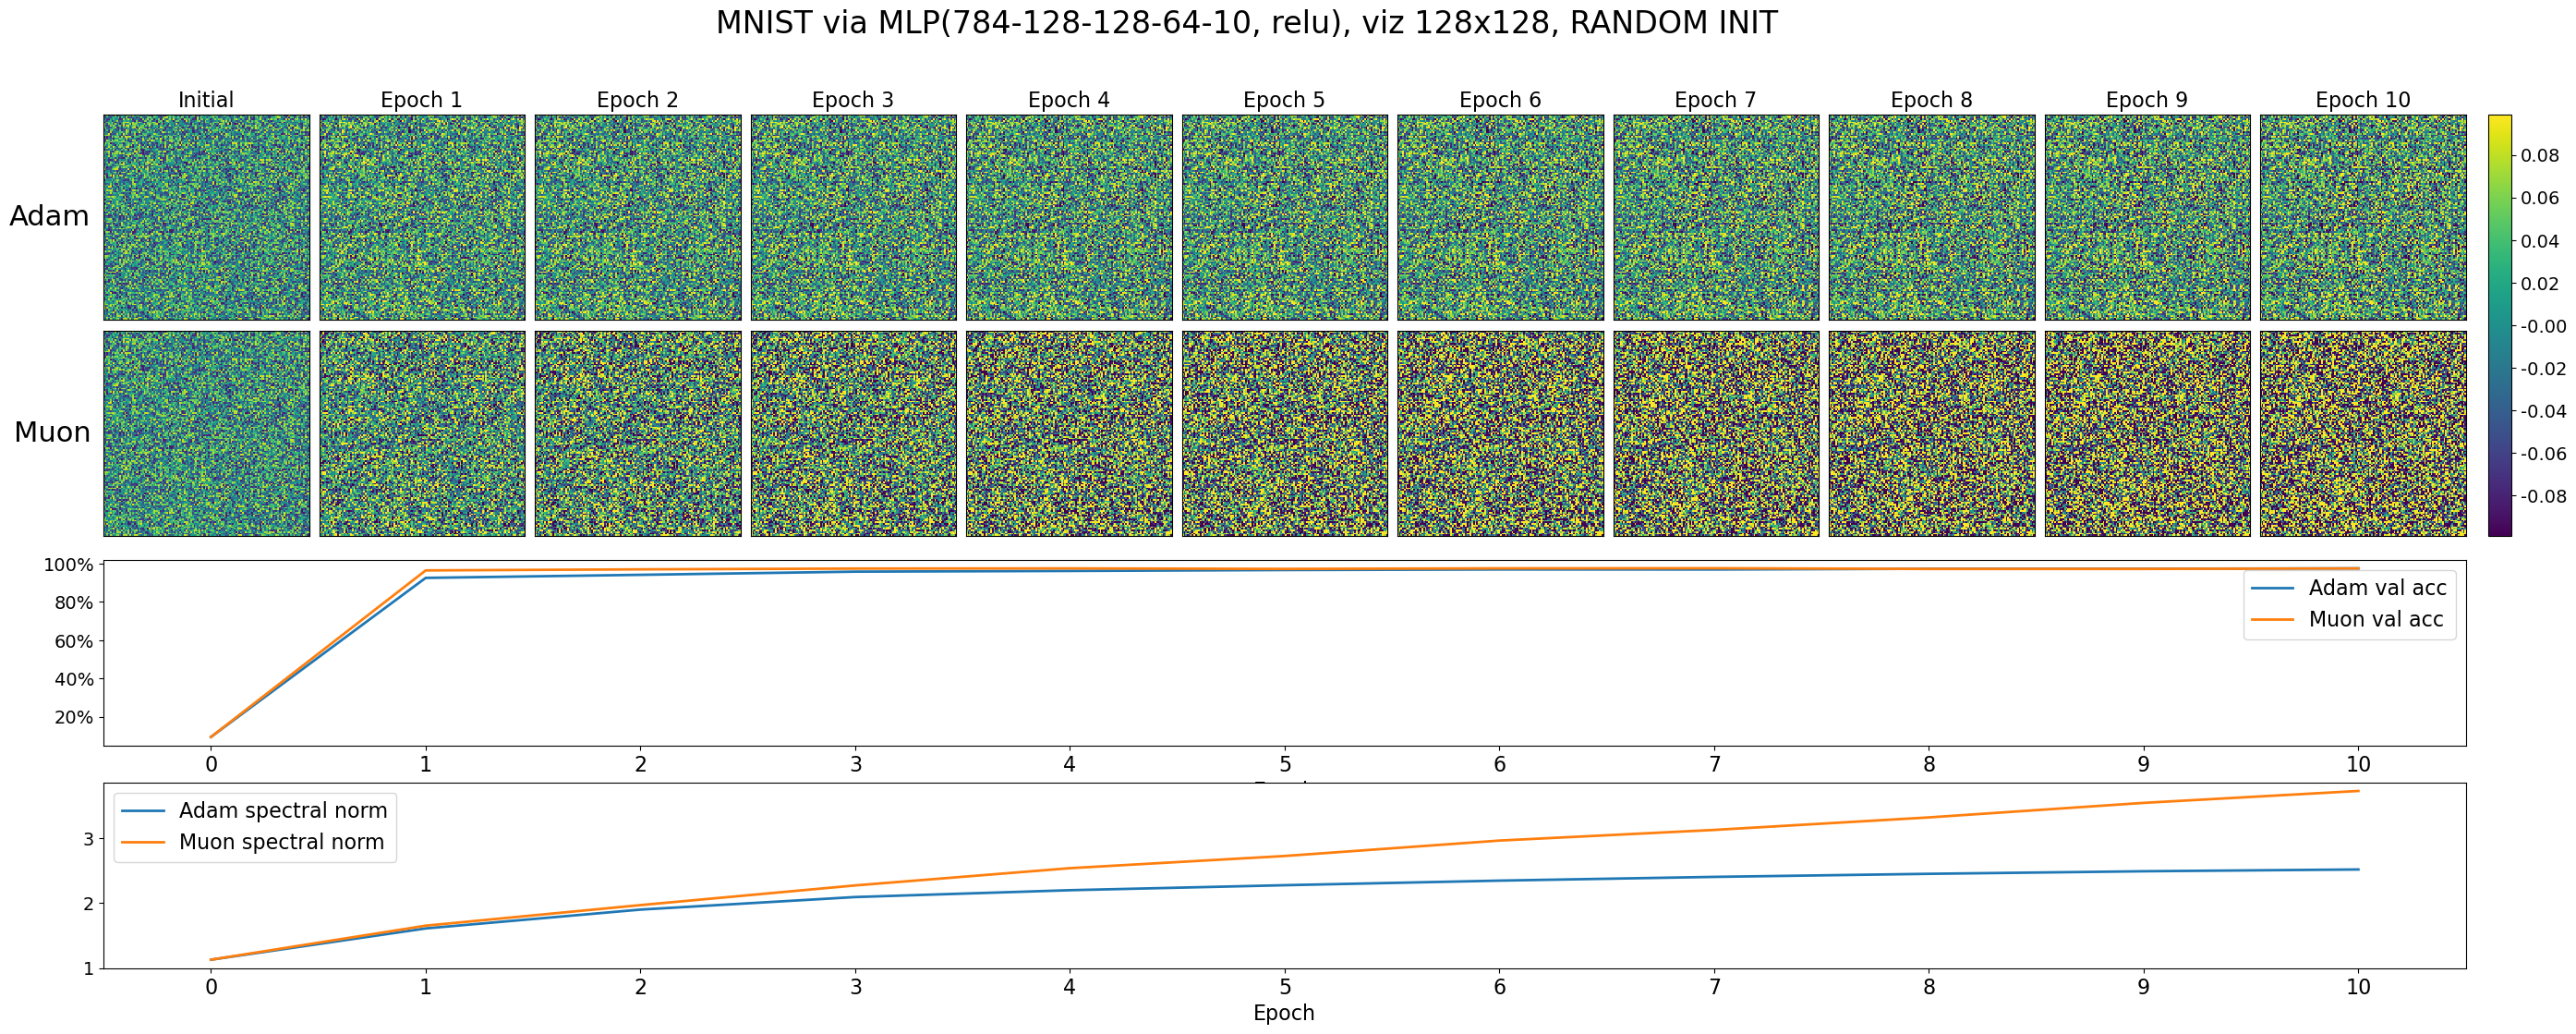

In [133]:
fig, axes = plt.subplots(4, 11, figsize=(11 * 3, 4 * 3), gridspec_kw=dict(wspace=0.05, hspace=0.05))

# Remove the individual axes in the bottom half
for i in range(2, axes.shape[0]):
    for j in range(axes.shape[1]):
        fig.delaxes(axes[i, j])
bottom_ax = fig.add_subplot(4, 1, 3)
bottom2_ax = fig.add_subplot(4, 1, 4)

fig.suptitle('MNIST via MLP(784-128-128-64-10, relu), viz 128x128, RANDOM INIT', fontsize=24, y=0.975)
axes[0, 0].set_ylabel('Adam', fontsize=22, rotation=0, ha='right', va='center', labelpad=10)
axes[1, 0].set_ylabel('Muon', fontsize=22, rotation=0, ha='right', va='center', labelpad=10)
vmin, vmax = -0.1, 0.1
for i, ax in enumerate(axes[0]):
    ax.set_title(f'Epoch {i}' if i > 0 else 'Initial', fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(rand_adam_res.model_ws[i].to('cpu', torch.float32).data, vmin=vmin, vmax=vmax, interpolation='nearest')
for i, ax in enumerate(axes[1]):
    ax.set_xticks([])
    ax.set_yticks([])
    im = ax.imshow(rand_muon_res.model_ws[i].to('cpu', torch.float32).data, vmin=vmin, vmax=vmax, interpolation='nearest')

cax = fig.add_axes([axes[1, -1].get_position().x1+0.0075, axes[1, -1].get_position().y0, 0.0075, axes[0, -1].get_position().y1-axes[1, -1].get_position().y0])
cb = fig.colorbar(im, cax=cax, ticks=torch.linspace(vmin-0.001, vmax+0.001, 11), format='%.2f')
cb.ax.tick_params(labelsize=14)

bottom_ax.plot(rand_adam_res.eval_accs, label='Adam val acc', linewidth=2)
bottom_ax.plot(rand_muon_res.eval_accs, label='Muon val acc', linewidth=2)
bottom_ax.set_xlabel('Epoch', fontsize=16)
bottom_ax.xaxis.set_ticks(range(len(adam_res.eval_accs)))
bottom_ax.xaxis.set_tick_params(labelsize=16)
bottom_ax.yaxis.set_tick_params(labelsize=14)
bottom_ax.legend(fontsize=16)
bottom_ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.0%}"))

bottom2_ax.plot([matrix_spectral_norm(w) for w in rand_adam_res.model_ws], label='Adam spectral norm', linewidth=2)
bottom2_ax.plot([matrix_spectral_norm(w) for w in rand_muon_res.model_ws], label='Muon spectral norm', linewidth=2)
bottom2_ax.set_xlabel('Epoch', fontsize=16)
bottom2_ax.xaxis.set_ticks(range(len(adam_res.eval_accs)))
bottom2_ax.xaxis.set_tick_params(labelsize=16)
bottom2_ax.yaxis.set_tick_params(labelsize=14)
bottom2_ax.legend(fontsize=16)
# fig.tight_layout()
fig